# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [3]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

In [4]:
# Additional import statements made here
np.int = np.int_
np.float = np.float_
# pip uninstall nltk
# pip install -U nltk
# restart notebook
import nltk
import zipfile
import shutil
import html
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#first, download the stopwords.zip file from https://www.nltk.org/nltk_data/ and then extract it
source_dir = '/Users/calebmccurdy/downloads/stopwords'
dest_dir = '/Users/calebmccurdy/nltk_data/corpora/stopwords'

if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)
shutil.move(source_dir, dest_dir)

#first, download the punkt.zip file from https://www.nltk.org/nltk_data/ and then extract it
punkt_source_dir = '/Users/calebmccurdy/downloads/punkt'
punkt_dest_dir = '/Users/calebmccurdy/nltk_data/corpora/punkt'

if os.path.exists(punkt_dest_dir):
    shutil.rmtree(punkt_dest_dir)
shutil.move(punkt_source_dir, punkt_dest_dir)

'/Users/calebmccurdy/nltk_data/corpora/punkt'

In [5]:
# Final remaining pre-loaded imports
from nltk.corpus import stopwords
sw = stopwords.words("english")
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [12]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/calebmccurdy/Desktop/USD/ADS 509/Lyrics Assignment/"

twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [53]:
# Read in the lyrics data

# Define path to the lyrics folder
lyrics_folder_path = os.path.join(data_location, lyrics_folder)

# Dictionary to store lyrics and title data
lyrics_data = {}
title_data = {}

# Loop through each artist subfolder in the lyrics folder
for artist_folder in os.listdir(lyrics_folder_path):
    artist_path = os.path.join(lyrics_folder_path, artist_folder)

    # Check if it's a directory
    if os.path.isdir(artist_path):
        artist = artist_folder
        lyrics_data.setdefault(artist, {})
        title_data.setdefault(artist, {})
        # Loop through each txt file in the artist subfolder
        for file_name in os.listdir(artist_path):
        
            # Extract song name from the file name
            song = os.path.splitext(file_name)[0]
            file_path = os.path.join(artist_path, file_name)
                
            # Read the entire text data from the file
            # https://www.dataquest.io/blog/read-file-python/ 
            with open(file_path, 'r') as file:
                skip = file.readline() 
                text_data = file.read()
                lyrics_data[artist][song] = text_data

            with open(file_path, 'r') as f:
                text_data_line = f.readline()
                title_data[artist][song] = text_data_line

# Now, we have the lyrics data in the 'lyrics_data' dictionary with artist and song names as keys.
# We also have the title data in the 'title_data' dictionary with artist and song names as keys.

In [14]:
# Read in the twitter data

# Define the path to the twitter folder
twitter_folder_path = os.path.join(data_location, twitter_folder)

# Dictionary to store Twitter descriptions
twitter_data = {}

# Loop through each txt file in the twitter folder
for file_name in os.listdir(twitter_folder_path):
    if file_name.endswith("_data.txt"):
        artist = file_name.split("_")[0]
        file_path = os.path.join(twitter_folder_path, file_name)
        df = pd.read_csv(file_path, sep='\t', quoting=3)

        # Extract the 'description' column from the DataFrame
        descriptions = df['description'].tolist()
        twitter_data[artist] = descriptions

# Now, we have the twitter followers description data in the 'twitter_data' dictionary with artist as the key.

In [22]:
positive_words_path = os.path.join(data_location, positive_words_file)
negative_words_path = os.path.join(data_location, negative_words_file)

# Read the positive/negative words from the file and ignore lines starting with ';'
positive_words = []
negative_words = []
with open(positive_words_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line and not line.startswith(';'):
            positive_words.append(line)
with open(negative_words_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line and not line.startswith(';'):
            negative_words.append(line)

positive_words_df = pd.DataFrame({'Word': positive_words, 'Score': 1})
negative_words_df = pd.DataFrame({'Word': negative_words, 'Score': -1})

print(positive_words_df)
print(negative_words_df)

           Word  Score
0            a+      1
1        abound      1
2       abounds      1
3     abundance      1
4      abundant      1
...         ...    ...
2001   youthful      1
2002       zeal      1
2003     zenith      1
2004       zest      1
2005      zippy      1

[2006 rows x 2 columns]
            Word  Score
0        2-faced     -1
1        2-faces     -1
2       abnormal     -1
3        abolish     -1
4     abominable     -1
...          ...    ...
4778        zaps     -1
4779      zealot     -1
4780     zealous     -1
4781   zealously     -1
4782      zombie     -1

[4783 rows x 2 columns]


In [23]:
positive_negative_df = pd.concat([positive_words_df, negative_words_df], ignore_index=True)

print("Combined Positive+Negative DataFrame:")
print(positive_negative_df)

Combined Positive+Negative DataFrame:
           Word  Score
0            a+      1
1        abound      1
2       abounds      1
3     abundance      1
4      abundant      1
...         ...    ...
6784       zaps     -1
6785     zealot     -1
6786    zealous     -1
6787  zealously     -1
6788     zombie     -1

[6789 rows x 2 columns]


In [31]:
tidy_text_path = os.path.join(data_location, tidy_text_file)

# Read tidy text sentiment words into a dataframe
tidy_text_df = pd.read_csv(tidy_text_path, sep='\t')
tidy_text_df['Score'] = tidy_text_df['sentiment'].apply(lambda x: 1 if x == 'positive' else -1)

tidy_scores_df = tidy_text_df[['word', 'Score']]
tidy_scores_df = tidy_scores_df.rename(columns={'word': 'Word'})

print("Tidytext Words Dataframe:")
print(tidy_scores_df.head(20))

Tidytext Words Dataframe:
              Word  Score
0          abandon     -1
1        abandoned     -1
2      abandonment     -1
3             abba      1
4        abduction     -1
5         aberrant     -1
6       aberration     -1
7            abhor     -1
8        abhorrent     -1
9          ability      1
10          abject     -1
11        abnormal     -1
12         abolish     -1
13       abolition     -1
14      abominable     -1
15     abomination     -1
16           abort     -1
17        abortion     -1
18        abortive     -1
19  abovementioned      1


In [33]:
word_sentiment_df = pd.concat([positive_negative_df, tidy_scores_df], ignore_index=True)

print("Combined Sentiment DataFrame:")
print(word_sentiment_df)

Combined Sentiment DataFrame:
            Word  Score
0             a+      1
1         abound      1
2        abounds      1
3      abundance      1
4       abundant      1
...          ...    ...
21917        win      1
21918     winner      1
21919    winners      1
21920    winning      1
21921     worthy      1

[21922 rows x 2 columns]


In [58]:
sentiments_df = word_sentiment_df.groupby('Word')['Score'].mean().reset_index()
sentiments_df['Score'] = sentiments_df['Score'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

print("Majority Sentiments DataFrame:")
print(sentiments_df)

Majority Sentiments DataFrame:
            Word  Score
0        2-faced     -1
1        2-faces     -1
2             a+      1
3        abandon     -1
4      abandoned     -1
...          ...    ...
11403     zenith      1
11404       zest      1
11405        zip     -1
11406      zippy      1
11407     zombie     -1

[11408 rows x 2 columns]


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [64]:
punctuation = set(punctuation) # speeds up comparison

whitespace_pattern = re.compile(r"\s+")

def tokenize(text) : 
    tokens = re.split(whitespace_pattern, text)
    return(tokens)

In [74]:
def clean_lyrics(text):
    if isinstance(text, str):
        # remove punctuation characters
        text = ''.join([char for char in text if char not in punctuation])
        # fold to lowercase
        text = text.lower()
        # remove stopwords
        text = ' '.join([word for word in text.split() if word.lower() not in sw])
        # remove extra white spaces
        text = re.sub(r'\s+', ' ', text)
        return text
    else:
        return ''

In [75]:
def sent_score(text):
    sentiment_score = 0
    cleaned_text = clean_lyrics(text)
    bag_of_words = tokenize(cleaned_text)
    #bag_of_words = clean_lyrics(text)

    for word in bag_of_words:
        if word in sentiments_df['Word'].values:
            sentiment_score += sentiments_df.loc[sentiments_df['Word'] == word, 'Score'].values[0]

    if len(bag_of_words) > 0:
        return sentiment_score / len(bag_of_words)
    else:
        return 0.0

In [76]:
lyrics_data_list = []
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        song_title = title_data.get(artist, {}).get(song, "")
        song_title = song_title.strip('"\n')
        lyrics_data_list.append({'Artist': artist, 'Song': song, 'Lyrics': lyrics, 'Song_Title': song_title})

# Create a DataFrame from the list of dictionaries
lyrics_df = pd.DataFrame(lyrics_data_list)
print("Lyrics DataFrame:")
print(lyrics_df.head())

Lyrics DataFrame:
  Artist                Song  \
0  robyn  robyn_includemeout   
1  robyn      robyn_electric   
2  robyn     robyn_beach2k20   
3  robyn     robyn_lovekills   
4  robyn   robyn_timemachine   

                                              Lyrics      Song_Title  
0  \n\n\nIt is really very simple\nJust a single ...  Include Me Out  
1  \n\n\nElectric...\n\nIt's electric\nIt's a nat...        Electric  
2  \n\n\n(So you wanna go out?\nHow you gonna get...      Beach 2K20  
3  \n\n\nIf you're looking for love\nGet a heart ...      Love Kills  
4  \n\n\nHey, what did I do?\nCan't believe the f...    Time Machine  


In [88]:
lyrics_df['Sentiment Score'] = lyrics_df['Lyrics'].apply(sent_score)
selected_columns = ['Artist', 'Song_Title', 'Lyrics', 'Sentiment Score']
song_sentiment_df = lyrics_df[selected_columns]

In [79]:
song_sentiment_df.head(20)

,Artist,Song_Title,Lyrics,Sentiment Score
0,robyn,Include Me Out,\n\n\nIt is really very simple\nJust a single ...,0.047210
1,robyn,Electric,\n\n\nElectric...\n\nIt's electric\nIt's a nat...,0.151316
2,robyn,Beach 2K20,\n\n\n(So you wanna go out?\nHow you gonna get...,0.151163
3,robyn,Love Kills,\n\n\nIf you're looking for love\nGet a heart ...,-0.098361
4,robyn,Time Machine,"\n\n\nHey, what did I do?\nCan't believe the f...",-0.062992
5,robyn,Love Kills,\n\n\nIf you're looking for love\nGet a heart ...,-0.097959
6,robyn,Giving You Back,\n\n\nIn another time\nAnother life\nIn anothe...,0.154545
7,robyn,None Of Dem,\n\n\nNone of these boys can dance\nNot a sing...,0.088710
8,robyn,None Of Dem,\n\n\nNone of these boys can dance\nNot a sing...,0.088710
9,robyn,Be Mine!,\n\n\nIt's a good thing tears never show in th...,0.028736


In [82]:
# Group by artist and calculate the mean sentiment score per song
sentiment_per_artist_df = lyrics_df.groupby('Artist')['Sentiment Score'].mean().round(3)
sentiment_per_artist_df

Artist
CityAlight    0.208
PatBarrett    0.187
cher          0.053
robyn         0.064
Name: Sentiment Score, dtype: float64

In [91]:
# Filter data for the artist 'CityAlight'
cityalight_df = lyrics_df[lyrics_df['Artist'] == 'CityAlight']

cityalight_highest_sentiments = cityalight_df.sort_values(by='Sentiment Score', ascending=False).head(3)
cityalight_lowest_sentiments = cityalight_df.sort_values(by='Sentiment Score', ascending=True).head(3)

# Display the song title, sentiment score, and lyrics of the songs with the highest sentiments
print("Top 3 Songs with Highest Sentiments for CityAlight:")
for idx, row in cityalight_highest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

# Display the song title, sentiment score, and lyrics of the songs with the lowest sentiments
print("\nTop 3 Songs with Lowest Sentiments for CityAlight:")
for idx, row in cityalight_lowest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

Top 3 Songs with Highest Sentiments for CityAlight:

Song Title: Good And Gracious King
Sentiment Score: 0.583
Lyrics:




I approach the throne of glory

Nothing in my hands I bring

But the promise of acceptance

From a good and gracious King



I will give to You my burden

As You give to me Your strength

Come and fill me with Your Spirit

As I sing to You this praise



You deserve the greater glory, and overcome, I lift my voice

To the King in need of nothing, empty handed I rejoice

You deserve the greater glory, and overcome with joy I sing

By Your love, I am accepted, 'cause You're a good and gracious King



And O what grace that You would see me

As Your child and as Your friend

Safe, secure in You forever

I pour out my praise again



'Cause You deserve the greater glory, and overcome, I lift my voice

To the King in need of nothing, empty handed I rejoice

'Cause You deserve the greater glory, and overcome with joy I sing

By Your love, I am accepted, 'cause You're a g

In [94]:
# Filter data for the artist 'Pat Barrett'
patbarrett_df = lyrics_df[lyrics_df['Artist'] == 'PatBarrett']

patbarrett_highest_sentiments = patbarrett_df.sort_values(by='Sentiment Score', ascending=False).head(3)
patbarrett_lowest_sentiments = patbarrett_df.sort_values(by='Sentiment Score', ascending=True).head(3)

# Display the song title, sentiment score, and lyrics of the songs with the highest sentiments
print("Top 3 Songs with Highest Sentiments for Pat Barrett:")
for idx, row in patbarrett_highest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

# Display the song title, sentiment score, and lyrics of the songs with the lowest sentiments
print("\nTop 3 Songs with Lowest Sentiments for Pat Barrett:")
for idx, row in patbarrett_lowest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

Top 3 Songs with Highest Sentiments for Pat Barrett:

Song Title: God Is So Good (You Are Worthy)
Sentiment Score: 0.609
Lyrics:




No height or depth can separate

Your steadfast love who can escape

Your faithfulness, an endless sea

So full of grace and mercy

We sing



God is so good

God is so good

God is so good

He's so good to me



Haunted by the past no more

My innocence has been restored

Forgiveness flows from Your veins

Your kindness shown in all Your ways

We sing



God is so good

God is so good

God is so good

He's so good to me



There's never been anyone like You

There's never been anyone like...

You are worthy, You are worthy

Never been anyone like You

Never been anyone like You

You are worthy, You are worthy



And hope is rising like the sun

The old is gone, the new has come

I fix my eyes on Christ alone

My Rock, my Shield, my Cornerstone

We sing



God is so good

God is so good

God is so good

He's so good to me (oh, You are)



God, You are goo

In [96]:
# Filter data for the artist 'Cher'
cher_df = lyrics_df[lyrics_df['Artist'] == 'cher']

cher_highest_sentiments = cher_df.sort_values(by='Sentiment Score', ascending=False).head(3)
cher_lowest_sentiments = cher_df.sort_values(by='Sentiment Score', ascending=True).head(3)

# Display the song title, sentiment score, and lyrics of the songs with the highest sentiments
print("Top 3 Songs with Highest Sentiments for Cher:")
for idx, row in cher_highest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

# Display the song title, sentiment score, and lyrics of the songs with the lowest sentiments
print("\nTop 3 Songs with Lowest Sentiments for Cher:")
for idx, row in cher_lowest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

Top 3 Songs with Highest Sentiments for Cher:

Song Title: My Love
Sentiment Score: 0.524
Lyrics:



When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my love does it good to me

Everywhere with my love
Don't you see my love
It does it so good
Oh, only my love, only my love
My love does it good

Don't ever ask me why
I never say "good-bye" to my love
It's understood
'Cause everywhere with my love
My love does it good, whoa
Only my love, oh only my love
My love does it good

Oh only my love
Only my love does it good to me,whoa



Song Title: Sunny
Sentiment Score: 0.456
Lyric

In [97]:
# Filter data for the artist 'Robyn'
robyn_df = lyrics_df[lyrics_df['Artist'] == 'robyn']

robyn_highest_sentiments = robyn_df.sort_values(by='Sentiment Score', ascending=False).head(3)
robyn_lowest_sentiments = robyn_df.sort_values(by='Sentiment Score', ascending=True).head(3)

# Display the song title, sentiment score, and lyrics of the songs with the highest sentiments
print("Top 3 Songs with Highest Sentiments for Robyn:")
for idx, row in robyn_highest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

# Display the song title, sentiment score, and lyrics of the songs with the lowest sentiments
print("\nTop 3 Songs with Lowest Sentiments for Robyn:")
for idx, row in robyn_lowest_sentiments.iterrows():
    rounded_sentiment = round(row['Sentiment Score'], 3)
    print(f"\nSong Title: {row['Song_Title']}")
    print(f"Sentiment Score: {rounded_sentiment}")
    print(f"Lyrics:\n{row['Lyrics']}\n")

Top 3 Songs with Highest Sentiments for Robyn:

Song Title: Baby Forgive Me
Sentiment Score: 0.52
Lyrics:



Here come the night
In your eyes
Baby, be brave
Be wise
It's up to you
You do what you like, mmm
Won't you give it a chance, baby?
Just one more try

Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me

(Won't you give it a chance, baby?)
Won't you give it a chance, baby?
Just one more try
One more try
Yeah, eh

You got the power
You set the price
But baby, be fair
Be nice
You say you want to be happy
Then you got to put your love on the line
Just let me make you smile again, baby
I know we can work it out
Yes, I know we can

Baby forgive me
Yeah
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me



Song Title: Love Is Free
Sentiment Score: 0.399
Lyrics:



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica b

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: CityAlight has the highest average sentiment score per song with a value of 0.208. Cher has the lowest with 0.053.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs with the highest sentiments for CityAlight are "Good And Gracious King", "God Is Over All", and "The Love Of The Father". The three songs with the lowest sentiments for CityAlight are "Washed By The Blood", "In Christ Alone (Live From Sydney)", and "Jesus Is Alive". 

For worship songs, the chorus is often repeated which will help drive the sentiment score. Specifically for the top song, the words "good", "gracious", and "holy" are repeated several times. With these being positive sentiment terms, the overall sentiment will be pointed in that direction. For the bottom 3 songs, they are all discussing death and sin which are obvious negative sentiment terms.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs with the highest sentiments for Pat Barrett are "God Is So Good (You Are Worthy)", "Sing Soul Sing", and "When I Look At The Blood". The three songs with the lowest sentiments for Pat Barrett are "Scatter", "No Body", and "Cada MaÃ±ana". 

Once again, worship songs often have choruses that are repeated which will help drive the sentiment score. Each of the top songs have a specific word repeated many times: good, hope/sing, and love. For instance, the top song has the word "good" show up 39 times! The bottom songs are in relation to "enemy" and "darkness" whicg bring their scores down despite having a good amount of positive sentiment words as well.

---

Q: For your third artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs with the highest sentiments for Cher are "My Love", "Sunny", and "Move Me". The three songs with the lowest sentiments for Cher are "Bang-Bang", "Bang Bang (My Baby Shot Me Down)", and "Cry Myself To Sleep". Among the top positive sentiment songs, they were all centered around the theme of love which is a positive word. Interestingly, two of the negative sentiment songs both had 'bang' as a reoccurring word. The other kept referencing the word 'cry' which helped bring the overall sentiment score down.

---

Q: For your fourth artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs with the highest sentiments for Robyn are "Baby Forgive Me", "Love Is Free", and "Between The Lines". The three songs with the lowest sentiments for Robyn are two renditions of "Don't F**king Tell Me What To Do" and "Criminal Intent". While having to ask for forgiveness implies a negative situation occured, the sentiment score of this song was still high as it leads to many instances of praise and suggestions of how great love could be. The words 'love', 'free' and 'like showed up often in the other two songs which led their scores to be positive. In the negative songs, the word 'killing' was in the majority of the line of the double-rendition while criminality and bad intentions were the topic of the other.

---

Q: Plot the distributions of the sentiment scores for each artist. You can use `seaborn` to plot densities or plot histograms in matplotlib.




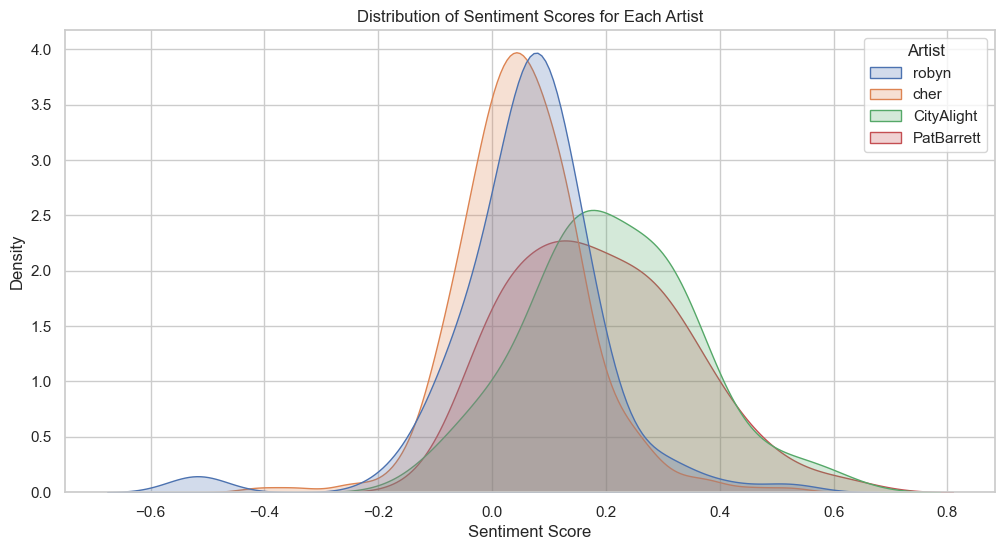

In [209]:
# Plot of the distributions of the sentiment scores for each artist
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.kdeplot(data=lyrics_df, x='Sentiment Score', hue='Artist', fill=True, common_norm=False)

# Set plot labels and title
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Density')
ax.set_title('Distribution of Sentiment Scores for Each Artist')

plt.show()

This density plot matches the takeaway from our average sentiment scoring. That is, the lyrics from Pat Barrett and CityAlight have higher positivity to them than the lyrics from Cher and Robyn. 

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [136]:
positive_emojis = {"\U0001F602", "\U00002764", "\U0001F499", "\U0001F495", "\U0001F48C", "\U0001F60D", "\U0001F618", "\U0001F60A", "\U0001F929", "\U00002728",
                   "\U0001F917", "\U0001F60E", "\U0001F602", "\U0001F49B", "\U0001F44D", "\U0001F44F", "\U0001F64C", "\U0001FAF6", "\U0001F64F","\U0001F525"}

negative_emojis = {"\U0001F44E", "\U0001F614", "\U0001F612", "\U0001F629", "\U0001F494", "\U0001F622", "\U0001F61E", "\U0001F62A", "\U0001F615",
                   "\U0001F621", "\U0001F62B", "\U0001F624", "\U0001F62C", "\U0001F623"}

In [141]:
# Create DataFrames for positive and negative emojis with a 'Score' column
positive_df = pd.DataFrame({'Emoji': list(positive_emojis), 'Score': 1})
negative_df = pd.DataFrame({'Emoji': list(negative_emojis), 'Score': -1})

# Concatenate positive and negative DataFrames
emojis_df = pd.concat([positive_df, negative_df], ignore_index=True)

print("Emojis DataFrame:")
print(emojis_df.head(3))

Emojis DataFrame:
  Emoji  Score
0     🙌      1
1     😊      1
2     ✨      1


In [166]:
def emoji_tokenize(text):
    tokens = re.split(r'', text)
    return tokens

In [168]:
def emoji_sent_score(text):
    emoji_sentiment_score = 0
    # Convert to string if not already a string
    text_str = str(text)
    
    bag_of_chars = emoji_tokenize(text_str)

    for emoji_used in bag_of_chars:
        if emoji_used in emojis_df['Emoji'].values:
            emoji_sentiment_score += emojis_df.loc[emojis_df['Emoji'] == emoji_used, 'Score'].values[0]

    return emoji_sentiment_score

In [143]:
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [175]:
# Because of the runtime, we will only take the first and last 5000 rows

first_5000_rows = twitter_data.head(5000)
last_5000_rows = twitter_data.tail(5000)

# Concatenate the two subsets into a new DataFrame
condensed_twitter_data = pd.concat([first_5000_rows, last_5000_rows])

print("Condensed Twitter Data:")
condensed_twitter_data

Condensed Twitter Data:


,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher
...,...,...,...,...,...,...,...,...
358367,jakegiles,Jake Giles,19725102,LA,7690,2165,"singer of songs, type 1 diabetic, tired $jakel...",robyn
358368,axelbluhme,Axel Bluhme,19573759,DK,238,1565,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,robyn
358369,RayRayRay27,Rachael :),19919217,Oldham,762,1479,A year to change a life is still a year ✨😌,robyn
358370,bhandberg,Ben Handberg,12642462,Sydney,432,593,Head of Consumer - Mango. Made in Melbourne. R...,robyn


In [176]:
condensed_twitter_data['Emoji Sentiment Score'] = condensed_twitter_data['description'].apply(emoji_sent_score)
selected_columns_twitter = ['artist', 'description', 'Emoji Sentiment Score']
condensed_twitter_sentiment_df = condensed_twitter_data[selected_columns_twitter]

In [177]:
condensed_twitter_sentiment_df

,artist,description,Emoji Sentiment Score
0,cher,NaN,0
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,0
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,0
3,cher,csu,0
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...,0
...,...,...,...
358367,robyn,"singer of songs, type 1 diabetic, tired $jakel...",0
358368,robyn,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,0
358369,robyn,A year to change a life is still a year ✨😌,1
358370,robyn,Head of Consumer - Mango. Made in Melbourne. R...,0


In [179]:
sentiment_per_artist_twitter = condensed_twitter_sentiment_df.groupby('artist')['Emoji Sentiment Score'].mean().round(3)
sentiment_per_artist_twitter

artist
cher     0.086
robyn    0.024
Name: Emoji Sentiment Score, dtype: float64

In [208]:
# Function to count the occurrences of each emoji
def count_emojis(text):
    text_str = str(text)
    emoji_counts = pd.Series(0, index=emojis_df['Emoji'])
    bag_of_chars = emoji_tokenize(text_str)
    for char in bag_of_chars:
        if char in emojis_df['Emoji'].values:
            emoji_counts[char] += 1
    return emoji_counts

# Group by artist
grouped_by_artist = condensed_twitter_sentiment_df.groupby('artist')['description']

# Create an empty DataFrame to store emoji amounts
emoji_amounts = pd.DataFrame()

# Apply the function to each artist's description
for artist, group in grouped_by_artist:
    emoji_amounts[artist] = group.apply(count_emojis).sum()

# Display the resulting DataFrame
print("Emoji Amounts DataFrame:")
emoji_amounts


Emoji Amounts DataFrame:


,cher,robyn
Emoji,,
🙌,2,1
😊,3,3
✨,92,15
🤩,6,1
🔥,20,6
🫶,0,0
😘,9,4
👏,5,5
🤗,5,1


Q: What is the average sentiment of your two artists? 

A: Based on the condensed data, which is likely to closely represent the overall data, the twitter description sentiment scores for Cher and Robyn were 0.086 and 0.024, respectively. Thus, the twitter followers of Cher on average have a more posiitve sentiment in their twitter descriptions based on emoji use only.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Based on the condensed data, the positive emoji that appeared the most in Cher's twitter follower descriptions is the heart ❤, while the most common negative emoji is broken heart 💔. The positive emoji that appeared the most in Robyn's twitter follower descriptions is also the heart ❤, while the most common negative emoji is the weary face 😫.